In [13]:
#------------------- Change working directory to project root -------------------#
from pathlib import Path, os

cur = Path().resolve()
while not (cur / "src").is_dir():
    if cur == cur.parent: raise RuntimeError("No 'src' dir")
    cur = cur.parent

os.chdir(cur)
print(f"[INFO] Changed working directory to project root: {cur}")

[INFO] Changed working directory to project root: /home/fernando/Documents/LoRaPriv


In [14]:
# -------------------------------------- External Libraries --------------------------------------
import numpy as np
import matplotlib.pyplot as plt
# ----------------------------------------- Local Imports ----------------------------------------
from src.core                  import LoRaPhyParams, LoRaFrameParams
from src.mod                   import LoRaModulator
from src.demod                 import LoRaDemodulator
from src.sync                  import DechirpBasedSynchronizer


import src.core.sdr_utils as sdr_utils

In [ ]:
def run_qualitative_test(sdr_params:sdr_utils.SDRParams, modulator:LoRaModulator, demodulator:LoRaDemodulator, synchronizer:DechirpBasedSynchronizer):
    phy_params = modulator.phy_params
    frame_params = modulator.frame_params

    to_transmit = [i for i in range(0, 2**phy_params.spreading_factor)]

    max_payload_len = sdr_utils.optimize_payload_symbols(
        buffer_len = sdr_params.rx_buffer_size,
        preamble_symbols= frame_params.preamble_symbol_count,
        samples_per_symbol = phy_params.samples_per_symbol,
        pad_samples = 0
    )

    print(f"Cantidad de símbolos máxima en una carga útil: {max_payload_len}.")

    rx_payloads = []

    # Distribuir los símbolos a transmitir en cargas útiles de longitud máxima o menor
    if len(to_transmit) > max_payload_len:
        payloads = [to_transmit[i:i + max_payload_len] for i in range(0, len(to_transmit), max_payload_len)]
    else:
        payloads = [to_transmit]
    
    for idx, payload in enumerate(payloads, start=1):
        print(f"Procesando payload {idx}/{len(payloads)}")

        print(f"1. Modulando un payload de {len(payload)} símbolos...")
        modulated_signal = modulator.modulate(payload, include_frame=True)

        sdr = sdr_utils.init_sdr(sdr_params)
        print(f"2. Transmitiendo la señal modulada a través de SDR como un buffer IQ...")
        sdr.tx((modulated_signal * (2**15 - 1)))

        received_signal = sdr.rx() / (2**15 - 1)
        print(f"3. Buffer IQ de SDR recibido")

        sdr_utils.soft_delete_sdr(sdr) 

        print(f"4. Sincronizando la señal recibida...")
        synchronized_signal = synchronizer.run(received_signal)

        print(f"5. Demodulando la señal sincronizada...")
        demodulated_payload = demodulator.demodulate(synchronized_signal)
        rx_payloads += demodulated_payload.tolist()

        demodulator.backend.clear_memory()

    print(f"Todas las cargas útiles han sido recibidas. Comprobando si coinciden con las enviadas...")

    # Asegurar la misma longitud
    min_len = min(len(to_transmit), len(rx_payloads))

    to_transmit = to_transmit[:min_len]
    rx_payloads = rx_payloads[:min_len]

    correct = np.array([int(to_transmit[i] == rx_payloads[i]) for i in range(min_len)])
    colors = np.where(correct, "green", "red")

    plt.figure(figsize=(18, 5))
    plt.scatter(to_transmit, rx_payloads, c=colors)
    plt.xlabel("Valor del símbolo transmitido")
    plt.ylabel("Valor del símbolo demodulado")
    plt.title("Gráfico de dispersión: Símbolo demodulado vs Transmitido")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    n_errors = np.count_nonzero(correct == 0)
    if n_errors > 0:
        print(f"Símbolos demodulados incorrectamente: {n_errors} de un total de {min_len} símbolos.")
    else:
        print("Todos los símbolos fueron demodulados correctamente.")

## Transmisión y Recepción de Payloads LoRa usando SDR

### ¿Qué hace este código?

En este notebook se ejecuta un ciclo completo de **transmisión, sincronización y demodulación** de múltiples payloads LoRa usando una radio SDR. Su objetivo es evaluar la **precisión cualitativa** (es decir, se enfoca en que el sistema funcione correctamente en condiciones **no límites**) del sistema al transmitir todos los posibles símbolos de una SF determinada.


### Etapas del proceso

1. **Inicialización de objetos LoRa**  

   Se crean instancias de:

   - `LoRaModulator`: para modular los datos.

   - `LoRaDemodulator`: para demodular tras la recepción.

   - `Synchronizer`: para detectar automáticamente el inicio de la trama.

2. **División de símbolos en payloads**  

   Se generan todos los símbolos posibles (`0` a `2^SF - 1`) y se dividen en payloads del tamaño máximo que puede transportar el buffer SDR $^1$ (`optimize_payload_length()`).

3. **Transmisión y recepción con SDR**  

   Para cada payload:

   - Se modula e inserta unas pocas muestras como padding al inicio.
   - Se transmite usando una radio SDR como buffer IQ.
   - Se recibe la señal y se sincroniza automáticamente.
   - Finalmente, se demodula para obtener los símbolos.


4. **Verificación de exactitud**  

   Se comparan los símbolos transmitidos con los recibidos.  
   Se genera un gráfico tipo *scatterplot* donde los aciertos aparecen en verde y los errores en rojo.

Este flujo representa un escenario real de uso con SDR donde:

- El sistema debe **alinearse automáticamente** a la trama recibida.
- Se valida que la **modulación, sincronización y demodulación** funcionen como una cadena robusta.
- Sirve para detectar problemas de exactitud en la transmisión de datos LoRa sobre canales reales.

$^1$ Se calcula que la trama completa (más el padding pasado como parámetro) debe entrar 3 veces de manera completa en el buffer (a nivel de muestras *crudas*). De esta forma, siempre en todo momento habrá al menos una trama entera disponible (la otra estaría cortada). Si no hay padding, se calcula que la trama completa debe entrar 2 veces de manera compĺeta en el buffer.


In [16]:
# --- Notebook Configuration ------------------------------------------
modulator_backend = "numpy"    # Use "numpy" for Modulator backend as it is better suited for MIMD
demodulator_backend = "cupy"   # Use "cupy" for Demodulator backend as it is optimized for SIMD
fold_mode = "0FPA"            

phy_params = LoRaPhyParams(
    spreading_factor=7,
    bandwidth=500e3,
    samples_per_chip=2
)

frame_params = LoRaFrameParams(
    preamble_symbol_count=8,
    explicit_header=True,
    sync_word=0x00
)

sdr_params = sdr_utils.SDRParams(
    uri = "ip:192.168.1.34",
    sample_rate = int(phy_params.sample_rate) ,
    lo_freq = 938e6,
    loopback_mode = sdr_utils.LoopbackMode.OTA,
    rf_bandwidth = int(phy_params.sample_rate),
    tx_attenuation = -29,
    rx_gain_control=sdr_utils.RxGainControl(sdr_utils.RxGainControlMode.MANUAL, 73),
    rx_buffer_size= 2**20
)

In [17]:
modulator = LoRaModulator(
    phy_params, 
    frame_params, 
    backend=modulator_backend
)

demodulator = LoRaDemodulator(
    phy_params,
    backend=demodulator_backend,
    fold_mode=fold_mode,
    return_peaks=False
)
synchronizer = DechirpBasedSynchronizer(
    phy_params,
    frame_params,
    backend=demodulator_backend,
    fold_mode=fold_mode,
    logging=False,
    max_sync_candidates=20
)

Maximum payload length for transmission: 2033 symbols.
Procesando payload 1/1
1. Modulando un payload de 128 símbolos...
2. Transmitiendo la señal modulada a través de SDR como un buffer IQ...
3. Buffer IQ de SDR recibido
SDR object soft deleted.
4. Sincronizando la señal recibida...
5. Demodulando la señal sincronizada...
Todas las cargas útiles han sido recibidas. Comprobando si coinciden con las enviadas...


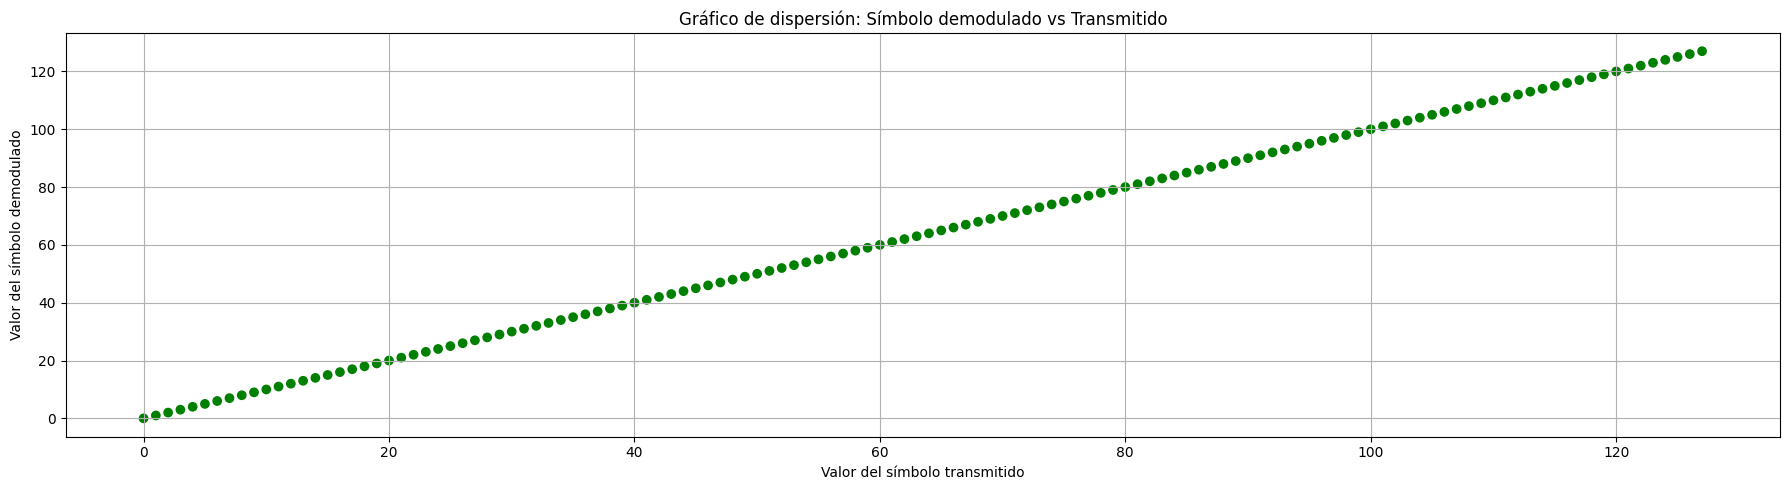

Todos los símbolos fueron demodulados correctamente.


In [18]:
run_qualitative_test(
    sdr_params= sdr_params,
    modulator=modulator,
    demodulator=demodulator,
    synchronizer=synchronizer
)